Se importan las librerias necesarias

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Se lee el dataset

In [294]:
df_train = pd.read_parquet('train.parquet')
df_test = pd.read_parquet('test.parquet')

Teniendo en cuenta que las siguientes columnas no aportan nada al modelo, se las va a eliminar del dataset como primer filtro 
- 'id'
- 'url'
- 'region_url'
- 'image_url'
- 'description'

In [295]:
df_train.drop(['id', 'url', 'region_url', 'image_url', 'description'], axis=1, inplace=True)
df_test.drop(['id', 'url', 'region_url', 'image_url', 'description'], axis=1, inplace=True)

Por otro lado, considerando que las variables 'region', 'state', 'lat', 'long' estan intimamente relacionadas y, considerando que las dos primeras tienen en sus valores una cantidad de categorias muy elevada, se eliminaran las mismas quedando solamente Latitud y Longitud como referentes de la localizacion de las casas

In [296]:
df_train.drop(['state', 'region'], axis=1, inplace=True)
df_test.drop(['state', 'region'], axis=1, inplace=True)

Se puede observar tambien que hay 196 filas del dataset de test que no tienen informacion de latitud y longitud. Dado a que este numero es insignificante ante la cantidad total de registros, se rellenaran las mismas con el promedio de cada una.

In [297]:
df_test['lat'].fillna(df_test['lat'].mean(), inplace=True)
df_test['long'].fillna(df_test['long'].mean(), inplace=True)

Se puede ver a continuacion que hay una cantidad de 169701 duplicados, los cuales se tendran que eliminar

In [298]:
df_train[df_train.duplicated]

,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long
280,899,apartment,1021,2,1.5,0,0,1,0,0,0,None,None,37.2867,-79.9957
315,1259,townhouse,1353,3,2.0,1,1,1,0,0,0,w/d hookups,street parking,38.4586,-77.4306
408,705,apartment,800,2,1.0,1,1,1,0,0,0,w/d hookups,carport,42.3113,-85.1874
458,589,apartment,480,0,1.0,1,1,1,0,0,0,None,None,30.6190,-96.3185
600,795,apartment,830,2,1.0,1,1,1,0,0,0,laundry on site,street parking,39.9230,-82.8664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346473,0,apartment,1100,2,1.0,0,0,0,0,0,1,w/d in unit,off-street parking,40.0091,-76.3671
346474,672,apartment,660,1,1.0,1,1,1,0,0,0,laundry on site,None,37.9591,-87.5293
346475,2122,apartment,1099,2,2.0,1,1,1,0,0,0,w/d in unit,off-street parking,32.6279,-117.0370
346476,1014,apartment,1104,2,2.0,1,1,0,0,0,0,w/d hookups,off-street parking,33.9659,-80.9355


In [299]:
df_train.drop_duplicates(inplace=True)

Se chequean los valores nulos del dataset de entrenamiento. Se puede ver que esta relativamente  completo sin cantidades considerables de estos. Los valores nulos que se hallan estan en las columnas longitud y latitud y, por ser una cantidad insignificante respecto al total, se ha decidido eliminar esas filas

In [300]:
df_train = df_train[~df_train['lat'].isna()]

Por otro lado, se analizan los valores faltantes de las columnas 'parking_options' y 'laundry_options', los cuales parecen no tener razon alguna.

In [301]:
df_train['parking_options'].value_counts()

off-street parking    57331
attached garage       26166
carport               17462
detached garage        9108
street parking         8040
no parking             1405
valet parking           113
Name: parking_options, dtype: int64

In [302]:
df_train['laundry_options'].value_counts()

w/d in unit           68143
w/d hookups           32823
laundry on site       21591
laundry in bldg       17989
no laundry on site     2625
Name: laundry_options, dtype: int64

Luego de haber visto las distribuciones de cada categoria en ambas variables, se ha determinado que se llenaran los valores nulos con la categoria predominante.
En el caso de 'parking_options' sera 'off-street parking' y para 'laundry_options' sera 'w/d in unit'

In [303]:
df_train['parking_options'].fillna('off-street parking', inplace=True)
df_train['laundry_options'].fillna('w/d in unit', inplace=True)

Antes de convertir la columna 'price' en categorica, se eliminaran aquellos ingresos que se consideren outliers, como ser los que tienen precio 0 y el que tenga un precio muy por encima del resto.
A continuacion se puede ver como los precios mas caros se encuentran en los millones y hay 1 solo de 27 trillones

In [304]:
df_train['price'].sort_values()

6519               0
314633             0
303679             0
228770             0
271525             0
             ...    
177615      11621360
297036      12000000
79076       18502000
98438       21701907
106214    2768307249
Name: price, Length: 175741, dtype: int64

In [305]:
df_train = df_train[(df_train['price'] != 0) & (df_train['price'] !=2768307249)]

Para convertir la columna 'price' en categorica se la dividira en 3 grupos ('Low', 'Medium', 'High)
Dichos grupos se dividiran de la siguiente forma:
- Low: [0-999]
- Medium: [1000-1999]
- High: [2000-30000000]

Dado que nuestro modelo solamente aceptara variables numericas y el objetivo del mismo es detectar si es Low o no, se le asignara el valor 1 a aquellos que se encuentren en la categoria Low y 0 a los que se encuentren en Medium y High

In [306]:
df_train = df_train.assign(low_price = pd.cut(df_train['price'], bins=[0,1000,2000,30000000], labels=[1, 0, 0], ordered=False))
df_train.drop(['price'], axis=1, inplace=True)


Se procesan las variables nominales: type, laundry_options, parking_options.
Se generan variables dummies para cada una ellas

In [307]:
df_train_proc = pd.get_dummies(df_train, columns=['type', 'laundry_options', 'parking_options'])
df_test_proc = pd.get_dummies(df_test, columns=['type', 'laundry_options', 'parking_options'])

    Una vez que el dataset esta preprocesado, se pasa al modelado.
    En este proceso se ha elegido trabajar con el metodo RandomForest dada su alta eficiencia para este tipo de dataset

Primero se va a instanciar el modelo

In [308]:
modelo = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)

Se realiza una division de entrenamiento y test para comprobar la exactitud y precision del modelo.
Se tomara 20% para el test y 80% para el entrenamiento.

In [309]:

X = df_train_proc.drop(['low_price'],axis=1)
y = df_train_proc['low_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Se entrena el modelo

In [310]:
modelo.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

Por ultimo, se realizan las predicciones tanto del conjunto de entrenamiento como el de testeo y se evalua el accuracy de ambos. En este caso se puede ver que se tiene un accuracy de 98.92% para el de entrenamiento y 94.36% para el de testeo lo cual demuestra cuan eficiente es el modelo.

In [311]:
y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.9908692085458501
0.8852112876993751


Se crea una matriz de confusion para ver la distribucion de las predicciones comparandolas con los valores verdaderos

In [230]:
matrix = confusion_matrix(y_train, y_train_pred)
matrix_2 = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(matrix)
matrix

array([[93947,   728],
       [  757, 62276]], dtype=int64)

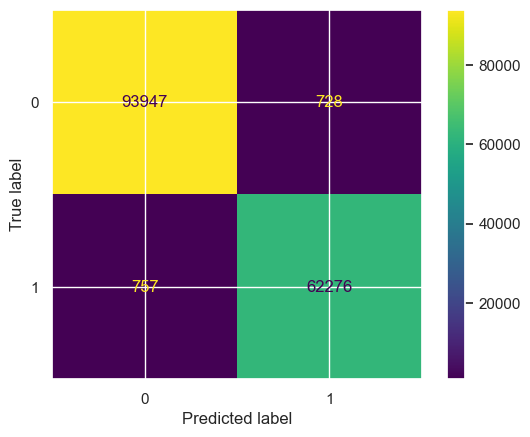

In [231]:
cm_display.plot()
plt.show()

Por ultimo, se va a predecir la variable objetivo con el set de test que se habia guardado de un principio, se la convierte en DataFrame y de ahi a csv.
Dado que en este dataset las columnas 'type_land' y 'type_assisted living' no existen pero deben estar ya que el modelo fue entrenado con dichas variables, se agregan al datasets con todos valores nulos.

In [232]:
d = pd.DataFrame(0, index=np.arange(len(df_test_proc)), columns=['type_land','type_assisted living'])
df_test_proc.insert(12,column='type_assisted living', value= d['type_assisted living'])
df_test_proc.insert(19,column='type_land', value= d['type_land'])

In [233]:
pred = modelo.predict(df_test_proc)

In [234]:
cristianpapini = pd.DataFrame(pred, columns=['pred'])

In [235]:
cristianpapini.to_csv('cristianpapini.csv', index=False)